In [13]:
using LinearAlgebra
using SparseArrays 
using StructArrays
using StaticArrays
using StaticRanges
using FastGaussQuadrature
using IterativeSolvers
using Preconditioners
using LinearSolve
using BenchmarkTools
using Profile
using ProfileView
using IncompleteLU
using Plots 

import AlgebraicMultigrid: ruge_stuben,smoothed_aggregation, aspreconditioner
using Test


In [2]:
# struct to hold a single mesh element
# all the members of the struct should be concrete type 
struct Element
    p1::Float64    # coordinate left-most node
    p2::Float64    # coordinate right-most node
    e1::Int64      # global index left-most node
    e2::Int64      # global index right-most node
    area::Float64  # area of the element 
  end
  
  # struct to hold entire mesh
  struct Mesh
    nnodes::Int64
    nelements::Int64 
    # specify one-dimensional array of elements as an array of structs. 
    # we worry about using structArray (if as all) later. 
    Elements::Array{Element,1}
    bndNodeIds::Vector{Int64}
    dofPerElement::Int64       
  end 

In [3]:
# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    dofPerElement = 2 
    x = Vector{Float64}(0:h:1)    
    # what does the undef do here? 
    Elements = Array{Element,1}(undef,nelements)
    for i in 1:nelements
        Elements[i] = Element(x[i],x[i+1],i,i+1,x[i+1]-x[i])
    end
    mesh = Mesh(nnodes,nelements,Elements,[1,nelements+1],dofPerElement)     
    return mesh;
end 

#mesh = genMesh(4)

genMesh (generic function with 1 method)

In [4]:
# generates local stiffness matrix 
function genLocStiffMat(element::Element, densityFunc)
    h     = element.area 
    e1    = element.e1
    e2    = element.e2
    Iloc  = SVector(e1, e1, e2, e2) 
    Jloc  = SVector(e1, e2, e1, e2) 
    
    p1 = element.p1
    p2 = element.p2
    c_avg = (densityFunc(p1) + densityFunc(p2)) / 2

    Aloc  = SVector(c_avg/h, -c_avg/h, -c_avg/h, c_avg/h) 
    return Iloc, Jloc, Aloc
end

# generate global stiffness matrix 
function genStiffMat(mesh::Mesh, densityFunc::C) where C
    
    #..recover number of elements  
    nelements = mesh.nelements
    dofperelem = 4; 
    
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofperelem*nelements)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, Jloc, Aloc = genLocStiffMat(element, densityFunc) 
        irng = mrange(dofperelem*i-dofperelem + 1,dofperelem*i) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc         
    end
    
    A = sparse(I,J,Avalues)

    #Dirichlet BC on left node
    A[mesh.bndNodeIds[1],1] = 1.
    A[mesh.bndNodeIds[1],2] = 0.
    #Neumann BC on right node - no need to change the matrix

    return A; 
end
     
#A = genStiffMat(mesh)
#println(A)

genStiffMat (generic function with 1 method)

In [5]:
function calcShapeFuncCoeff(degree)
    numpoints = degree + 1
    points = Vector(LinRange(-1,1,numpoints))
    points
    coeffs = zeros(Float64,numpoints,numpoints)
    x,w = gausslegendre(numpoints)
end

calcShapeFuncCoeff(2)

([-0.7745966692414834, 0.0, 0.7745966692414834], [0.5555555555555556, 0.8888888888888888, 0.5555555555555556])

In [6]:
function genLocVec(element, sourceFct)
    h = element.area 
    Iloc = SVector(element.e1, element.e2)
    floc = (h/2)*SVector(sourceFct(element.p1), sourceFct(element.p2))
    return Iloc, floc
end

function genVector(mesh, sourceFct::F) where F 
    
    #..recover number of elements  
    nelements = mesh.nelements 
    nnodes = mesh.nnodes 
    
    #..initialize global vector  
    f = zeros(Float64,nnodes)

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, floc = genLocVec(element,sourceFct) 
        f[Iloc] .+= floc          
    end

    #Boundary conditions
    f[mesh.bndNodeIds[1]] = 0.
    f[mesh.bndNodeIds[2]] = 0.
   
    return f; 
end

#f = genVector(mesh,fsource)
#println(f)
     

genVector (generic function with 1 method)

In [7]:
# generates local mass matrix 
function genLocMassMat(element::Element)
    h     = element.area 
    e1    = element.e1
    e2    = element.e2
    Iloc  = SVector(e1, e2) 
    Jloc  = SVector(e1, e2) 
    Aloc  = SVector(h /2 , h/2) 
    return Iloc, Jloc, Aloc
end

# generate global mass matrix 
function genMassMat(mesh::Mesh)
    
    #..recover number of elements  
    nelements = mesh.nelements
    dofperelem = 2
    
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofperelem*nelements)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, Jloc, Aloc = genLocMassMat(element) 
        irng = mrange(dofperelem*i - dofperelem + 1,dofperelem*i) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc         
    end
    
    A = sparse(I,J,Avalues)
   
    return A; 
end
mesh = genMesh(4)
genMassMat(mesh)

5×5 SparseMatrixCSC{Float64, Int64} with 5 stored entries:
 0.125   ⋅     ⋅     ⋅     ⋅ 
  ⋅     0.25   ⋅     ⋅     ⋅ 
  ⋅      ⋅    0.25   ⋅     ⋅ 
  ⋅      ⋅     ⋅    0.25   ⋅ 
  ⋅      ⋅     ⋅     ⋅    0.125

sparse([1, 2, 1, 

2, 3, 2, 3, 4, 3, 4, 5, 4, 5, 6, 5, 6, 7, 6, 7, 8, 7, 8, 9, 8, 9, 10, 9, 10, 11, 10, 11, 12, 11, 12, 13, 12, 13, 14, 13, 14, 15, 14, 15, 16, 15, 16, 17, 16, 17, 18, 17, 18, 19, 18, 19, 20, 19, 20, 21, 20, 21, 22, 21, 22, 23, 22, 23, 24, 23, 24, 25, 24, 25, 26, 25, 26, 27, 26, 27, 28, 27, 28, 29, 28, 29, 30, 29, 30, 31, 30, 31, 32, 31, 32, 33, 32, 33, 34, 33, 34, 35, 34, 35, 36, 35, 36, 37, 36, 37, 38, 37, 38, 39, 38, 39, 40, 39, 40, 41, 40, 41, 42, 41, 42, 43, 42, 43, 44, 43, 44, 45, 44, 45, 46, 45, 46, 47, 46, 47, 48, 47, 48, 49, 48, 49, 50, 49, 50, 51, 50, 51, 52, 51, 52, 53, 52, 53, 54, 53, 54, 55, 54, 55, 56, 55, 56, 57, 56, 57, 58, 57, 58, 59, 58, 59, 60, 59, 60, 61, 60, 61, 62, 61, 62, 63, 62, 63, 64, 63, 64, 65, 64, 65, 66, 65, 66, 67, 66, 67, 68, 67, 68, 69, 68, 69, 70, 69, 70, 71, 70, 71, 72, 71, 72, 73, 72, 73, 74, 73, 74, 75, 74, 75, 76, 75, 76, 77, 76, 77, 78, 77, 78, 79, 78, 79, 80, 79, 80, 81, 80, 81, 82, 81, 82, 83, 82, 83, 84, 83, 84, 85, 84, 85, 86, 85, 86, 87, 86, 87,

[1.0, -100.0, 0.0, 200.0, -100.0, -100.0, 200.0, -100.00000000000001, -100.00000000000001, 200.0, -99.99999999999999, -99.99999999999999, 199.99999999999997, -99.99999999999999, -99.99999999999999, 200.00000000000006, -100.00000000000006, -100.00000000000006, 199.99999999999997, -99.99999999999991, -99.99999999999991, 199.99999999999997, -100.00000000000006, -100.00000000000006, 200.0000000000001, -100.00000000000006, -100.00000000000006, 199.99999999999997, -99.99999999999991, -99.99999999999991, 199.99999999999997, -100.00000000000006, -100.00000000000006, 200.0000000000001, -100.00000000000006, -100.00000000000006, 199.99999999999997, -99.99999999999991, -99.99999999999991, 199.99999999999983, -99.99999999999991, -99.99999999999991, 200.0000000000001, -100.00000000000018, -100.00000000000018, 200.0000000000001, -99.99999999999991, -99.99999999999991, 199.99999999999983, -99.99999999999991, -99.99999999999991, 200.0000000000001, -100.00000000000018, -100.00000000000018, 200.000000000

)

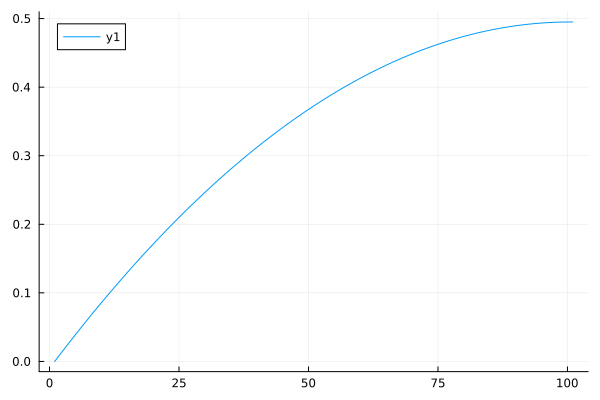

In [8]:
mesh = genMesh(100)
c(x) = 1
S = genStiffMat(mesh,c)
M = genMassMat(mesh)
fsource(x) = 1
f = genVector(mesh,fsource)


print(S)
#u = (S + M) \ f
u = S \ f
plot(u)

As group 5 we saw that storing the matrix as a Tridiagonal type works way better with the "\\" operator so we need to convert the sparse matrixes to tridiagonal ones

In [9]:
A = S + M;
A = Tridiagonal(A);

Now we want to see the differences between assemblying time and resolving time. The function solve_and_write_time calculates the elapsed time to Assembly the matrix and to solve the linear problem depending on the dimension of the problem: n. To solve it we are using different algorithms, the direct \\ after using the LU decomposition on a Tridiagonal matrix and the preconditioned conjugate method using the ILU preconditioner. The iterating solving method is precise to 10^-14 

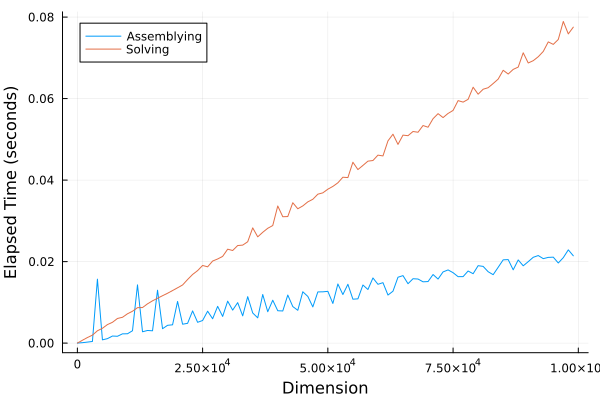

In [10]:
function solve_and_write_time(n)
    
    ret = zeros(2);
    # Measure the time to solve the linear system
    elapsed_time_assembly = @elapsed begin
        mesh = genMesh(n)
        c(x) = 1
        S = genStiffMat(mesh,c)
        M = genMassMat(mesh)
        fsource(x) = 1
        f = genVector(mesh,fsource)
        A = S + M;
        A = Tridiagonal(A);
    end
    ret[1] = elapsed_time_assembly

    elapsed_time_solving = @elapsed begin
        u = A \ f
    end
    ret[2] = elapsed_time_solving

    return ret
end

# Set the dimensions for the loop (e.g., from 2 to 100000 with a step of 1000)
dimensions = 2:1000:100000
times_assembly = []
times_solving = []

# Solve linear systems and collect elapsed times
for n in dimensions
    time = solve_and_write_time(n)
    push!(times_assembly, time[1])
    push!(times_solving, time[2])
end

# Plot the graph
plot(dimensions, times_assembly, xlabel="Dimension", ylabel="Elapsed Time (seconds)", label="Assemblying", legend=:topleft)
plot!(dimensions, times_solving, label="Solving")

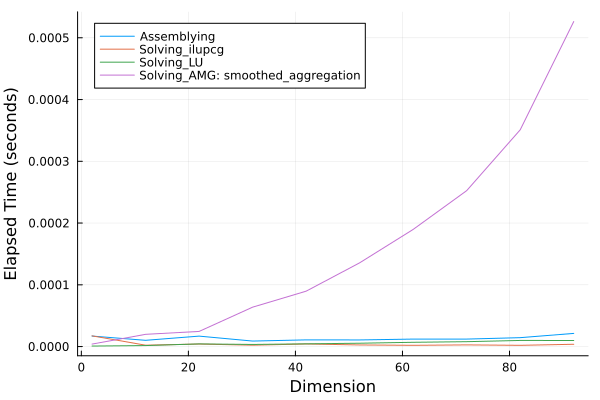

In [15]:
function LU_pre(m)
    return lu(m)
end

function LU_calc(lu, f)
    return lu\f
end

function backslash(m::Tridiagonal{Float64, Vector{Float64}}, f::Vector{Float64})
    return m\f
end

function solve_and_write_time(n)
    reltol = 1e-6
    
    ret = zeros(5);
    # Measure the time to solve the linear system
    elapsed_time_assembly = @elapsed begin
        mesh = genMesh(n)
        c(x) = 1
        S = genStiffMat(mesh,c)
        M = genMassMat(mesh)
        fsource(x) = 1
        f = genVector(mesh,fsource)
        A = S + M;
    end
    ret[1] = elapsed_time_assembly
    preconditioner = ilu(A)
    elapsed_time_solving = @elapsed begin
        x = cg(A, f, Pl=preconditioner)
    end
    ret[2] = elapsed_time_solving

    #=
    ml_rs = ruge_stuben(A)
    p_rs = aspreconditioner(ml_rs)

    elpased_time_AMGrs= @elapsed begin
        x = cg(A, f, Pl = p_rs, reltol =reltol)
    
    end
    

    ret[4]= elpased_time_AMGrs 
    =#

    #=
    ml_sa = smoothed_aggregation(A)
    p_sa = aspreconditioner(ml_sa)

    elpased_time_AMGsa= @elapsed begin
        x = cg(A, f, Pl = p_sa, reltol =reltol)
    
    end

    ret[5]= elpased_time_AMGsa 
    =#
    A=Tridiagonal(A)
    luMat = LU_pre(A)
    elapsed_time_LU = @elapsed begin
        x = LU_calc(luMat, f)
    end
    ret[3]=elapsed_time_LU

    return ret
end

# Set the dimensions for the loop (e.g., from 2 to 100000 with a step of 1000)
dimensions = 2:10:100
times_assembly = []
times_solving = []
times_LU = []
#times_AMGrs = []
times_AMGsa = []

# Solve linear systems and collect elapsed times
for n in dimensions
    time = solve_and_write_time(n)
    push!(times_assembly, time[1])
    push!(times_solving, time[2])
    push!(times_LU,time[3])
    #push!(times_AMGrs,time[4])
    #push!(times_AMGsa,time[5])
end

# Plot the graph
plot(dimensions, times_assembly, xlabel="Dimension", ylabel="Elapsed Time (seconds)", label="Assemblying", legend=:topleft, log=true)
plot!(dimensions, times_solving, label="Solving_ilupcg", log=true)
plot!(dimensions,times_LU, label="Solving_LU", log=true)
#plot!(dimensions,times_AMGrs, label="Solving_AMG: ruge_stuben", log=true)
#plot!(dimensions,times_AMGsa, label="Solving_AMG: smoothed_aggregation", log=true)

AlgebraicMultigrid

In [ ]:



A = poisson((50,50))
b = A * ones(size(A,1))

display(A)
display(b)

reltol = 1e-8

for method in [ruge_stuben, smoothed_aggregation]
    ml = method(A)
    display(ml)

    for cycle in [AlgebraicMultigrid.V(),AlgebraicMultigrid.W(),AlgebraicMultigrid.F()]
        x,convhist = AlgebraicMultigrid._solve(ml, b, cycle; reltol = reltol, log = true)

        @debug "number of iterations for $cycle using $method: $(length(convhist))"
        @test norm(b - A*x) < reltol * norm(b)
    end

    for cycle in [AlgebraicMultigrid.V(),AlgebraicMultigrid.W(),AlgebraicMultigrid.F()]
        p = aspreconditioner(ml,cycle)

        x,convhist = cg(A, b, Pl = p; reltol = reltol, log = true)
        print("CG: number of iterations for $cycle using $method: $(convhist.iters)")
        @test norm(b - A*x) <= reltol * norm(b)
    end
end
